In [1]:
%load_ext autoreload
%autoreload 2

# FiNER-139 dataset analysis

Dataset [reference](https://huggingface.co/datasets/nlpaueb/finer-139?row=0) and [paper](https://arxiv.org/abs/2203.06482).

This dataset focuses on Financial entities, as it comprises 1.1M sentences annotated with eXtensive Business Reporting Language (XBRL) tags.

- Language: English.
- Market: US.
- Sample:
    ```
    {
        'id': 40
        'tokens': ['In', 'March', '2014', ',', 'the', 'Rialto', 'segment', 'issued', 'an', 'additional', '$', '100', 'million', 'of', 'the', '7.00', '%', 'Senior', 'Notes', ',', 'at', 'a', 'price', 'of', '102.25', '%', 'of', 'their', 'face', 'value', 'in', 'a', 'private', 'placement', '.']
        'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 37, 0, 0, 0, 41, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    }
    ```


## Checking out the dataset

Let's start by checking out what we get by loading the dataset with huggingface.

In [2]:
import datasets

ds = datasets.load_dataset("nlpaueb/finer-139")
print(ds)

/home/roelschr/workspace/finer-139-task/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 900384
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 112494
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 108378
    })
})


In [3]:
tags = ds["train"].features["ner_tags"].feature.names
print(tags)

['O', 'B-AccrualForEnvironmentalLossContingencies', 'B-AcquiredFiniteLivedIntangibleAssetsWeightedAverageUsefulLife', 'I-AcquiredFiniteLivedIntangibleAssetsWeightedAverageUsefulLife', 'B-AllocatedShareBasedCompensationExpense', 'B-AmortizationOfFinancingCosts', 'B-AmortizationOfIntangibleAssets', 'I-AmortizationOfIntangibleAssets', 'B-AntidilutiveSecuritiesExcludedFromComputationOfEarningsPerShareAmount', 'I-AntidilutiveSecuritiesExcludedFromComputationOfEarningsPerShareAmount', 'B-AreaOfRealEstateProperty', 'I-AreaOfRealEstateProperty', 'B-AssetImpairmentCharges', 'B-BusinessAcquisitionEquityInterestsIssuedOrIssuableNumberOfSharesIssued', 'B-BusinessAcquisitionPercentageOfVotingInterestsAcquired', 'I-BusinessAcquisitionPercentageOfVotingInterestsAcquired', 'B-BusinessCombinationAcquisitionRelatedCosts', 'B-BusinessCombinationConsiderationTransferred1', 'B-BusinessCombinationContingentConsiderationLiability', 'B-BusinessCombinationRecognizedIdentifiableAssetsAcquiredAndLiabilitiesAssum

To clear things out, the `B-` prefix denotes the beginning of the named entity. The `I-` prefix means that this token is inside the named entity. The `O-` tag means that the corresponding word is not an entity. This means `I-` should always come with a `B-`, therefore it won't make sense to select `I-` tags without their respective `B-` tags, especially with FiNER-139. This dataset is especially complex because most of the entities are numerical values. This means that the context around the entity matters a lot more when we compare this with other NER tasks.

In [4]:
prefix_splits = {"B": set(), "I": set()}

for t in tags[1:]:
    prefix, tag = t.split("-")
    prefix_splits[prefix].add(tag)

print(prefix_splits)    

{'B': {'CashAndCashEquivalentsFairValueDisclosure', 'DerivativeNotionalAmount', 'OperatingLeaseExpense', 'LineOfCreditFacilityRemainingBorrowingCapacity', 'StockIssuedDuringPeriodSharesNewIssues', 'SharebasedCompensationArrangementBySharebasedPaymentAwardExpirationPeriod', 'LongTermDebt', 'StockRepurchasedAndRetiredDuringPeriodShares', 'GoodwillImpairmentLoss', 'DefinedBenefitPlanContributionsByEmployer', 'LossContingencyDamagesSoughtValue', 'RelatedPartyTransactionExpensesFromTransactionsWithRelatedParty', 'Revenues', 'StockRepurchasedDuringPeriodShares', 'IncomeLossFromEquityMethodInvestments', 'EmployeeServiceShareBasedCompensationNonvestedAwardsTotalCompensationCostNotYetRecognized', 'PreferredStockSharesAuthorized', 'ShareBasedCompensationArrangementByShareBasedPaymentAwardEquityInstrumentsOtherThanOptionsGrantsInPeriod', 'TreasuryStockValueAcquiredCostMethod', 'RepaymentsOfDebt', 'AntidilutiveSecuritiesExcludedFromComputationOfEarningsPerShareAmount', 'TreasuryStockSharesAcquired

In [5]:
prefix_splits["B"].symmetric_difference(prefix_splits["I"])

set()

So, all tags can have multiple tokens. Now, let's take a quick look into `B-` tags distribution and an idea of which ones come in multiple tokens more often. For that we'll be using a sample of the train set.

In [6]:
train_sample = ds["train"].shuffle(42).select(range(ds["train"].num_rows//2))
train_sample, train_sample.data

(Dataset({
     features: ['id', 'tokens', 'ner_tags'],
     num_rows: 450192
 }),
 ConcatenationTable
 id: int32
 tokens: list<item: string>
   child 0, item: string
 ner_tags: list<item: int64>
   child 0, item: int64
 ----
 id: [[0,1,2,3,4,...,995,996,997,998,999],[1000,1001,1002,1003,1004,...,1995,1996,1997,1998,1999],...,[899000,899001,899002,899003,899004,...,899995,899996,899997,899998,899999],[900000,900001,900002,900003,900004,...,900379,900380,900381,900382,900383]]
 tokens: [[["ITEM","1","Financial","Statements","Lennar",...,"in","Lennar","Multifamily","assets","."],["See","accompanying","notes","to","condensed",...,"“","Company","”",")","."],...,["In","addition",",","the","Company",...,"November","30",",","2015","."],["The","Company","’","s","financial",...,",","2015",",","respectively","."]],[["Additionally",",","at","August","31",...,"related","to","pending","litigation","."],["As","of","August","31",",",...,"to","these","site","improvements","."],...,["As","a","result","

In [7]:
# counting documents
counter_docs = [0]*len(tags)
for s in train_sample:
    counted = [0]*len(tags)
    for t in s["ner_tags"]:
        if not counted[t]:
            counter_docs[t] += 1
            counted[t] = 1


In [8]:
# counting documents
counter_tokens = [0]*len(tags)
for s in train_sample:
    for t in s["ner_tags"]:
        counter_tokens[t] += 1

In [9]:
import pandas as pd

counter_df = pd.DataFrame({"tag": tags, "n_docs": counter_docs, "n_tokens": counter_tokens})
counter_df["prefix"] = counter_df["tag"].str.extract("(B-|I-)")
counter_df.sort_values("n_tokens", ascending=False).head()

,tag,n_docs,n_tokens,prefix
0,O,450192,20265782,NaN
41,B-DebtInstrumentInterestRateStatedPercentage,5298,7669,B-
87,B-LineOfCreditFacilityMaximumBorrowingCapacity,4287,5833,B-
34,B-DebtInstrumentBasisSpreadOnVariableRate1,2666,5756,B-
37,B-DebtInstrumentFaceAmount,4163,5378,B-


<Axes: ylabel='tag'>

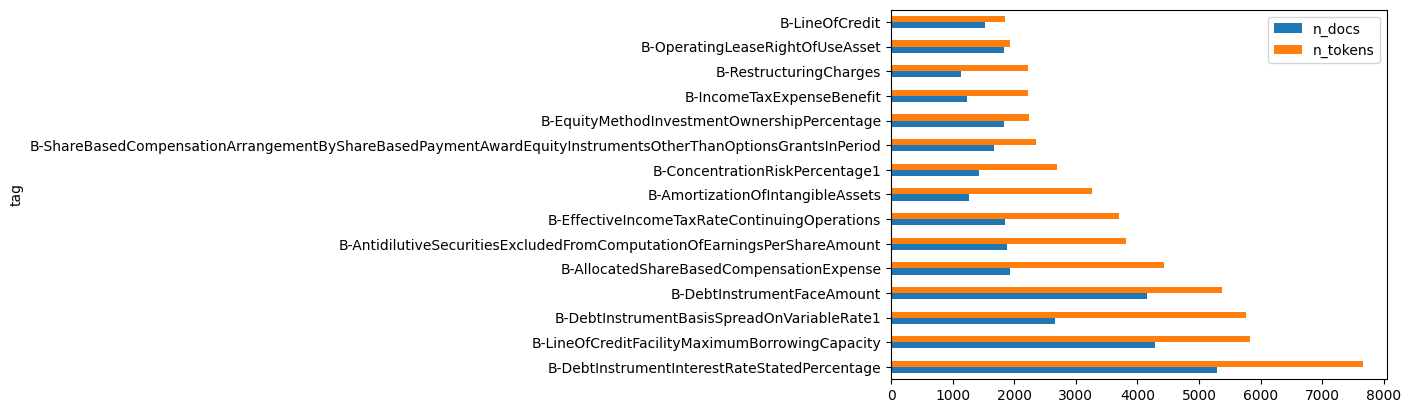

In [10]:
counter_df[counter_df["prefix"]=="B-"].sort_values(by=["n_tokens"], ascending=False)[:15].plot.barh(x="tag")

In [11]:
counter_df[counter_df["prefix"]=="B-"].sort_values(by=["n_tokens"], ascending=False)[:15]

,tag,n_docs,n_tokens,prefix
41,B-DebtInstrumentInterestRateStatedPercentage,5298,7669,B-
87,B-LineOfCreditFacilityMaximumBorrowingCapacity,4287,5833,B-
34,B-DebtInstrumentBasisSpreadOnVariableRate1,2666,5756,B-
37,B-DebtInstrumentFaceAmount,4163,5378,B-
4,B-AllocatedShareBasedCompensationExpense,1929,4426,B-
8,B-AntidilutiveSecuritiesExcludedFromComputatio...,1887,3810,B-
57,B-EffectiveIncomeTaxRateContinuingOperations,1849,3695,B-
6,B-AmortizationOfIntangibleAssets,1271,3259,B-
30,B-ConcentrationRiskPercentage1,1422,2687,B-
140,B-ShareBasedCompensationArrangementByShareBase...,1677,2360,B-


In [12]:
most_common = counter_df[counter_df["prefix"]=="B-"].sort_values(by=["n_tokens"], ascending=False)[:15].index.tolist()
most_common

[41, 87, 34, 37, 4, 8, 57, 6, 30, 140, 64, 74, 128, 107, 83]

## Selecting tags

Above we can see the most common tags (`B-` prefix) in a random 50% sample of the train set. Instead of choosing the top 4 for our training (because we have more data about them), let's instead try visualizing which ones appear together more often. 

I have limited knowledge of the matter, so I would usually ask the experts on ways that we can filter and select the most relevant tags. But given I don't have access to one right now, selecting tags that appear together more often will filter our dataset to a common topic. Tags with co-appeareance indicate similar documents and thus help us filter down the context in which the model shall operate.

In [13]:
import numpy as np
counter = np.zeros((len(tags), len(tags)))
for s in train_sample:
    filtered = list(set(s["ner_tags"]))
    for x in range(len(filtered)):
        counted = [0]*len(tags)
        counter[filtered[x], filtered[x]] += 1
        counted[filtered[x]] = 1
        for y in range(x+1, len(filtered)):
            if not counted[filtered[y]]:
                counter[filtered[x], filtered[y]] += 1
                counter[filtered[y], filtered[x]] += 1
                counted[filtered[y]] = 1

counter


array([[450192.,    452.,    620., ...,      0.,      0.,      0.],
       [   452.,    452.,      0., ...,      0.,      0.,      0.],
       [   620.,      0.,    620., ...,      0.,      0.,      0.],
       ...,
       [     0.,      0.,      0., ...,      0.,      0.,      0.],
       [     0.,      0.,      0., ...,      0.,      0.,      0.],
       [     0.,      0.,      0., ...,      0.,      0.,      0.]])

In [14]:
assert np.array_equal(counter.diagonal(), counter_df["n_docs"].values), "Got the counter wrong"

In [15]:
best_tag = 0
max_tokens = 0

for v in most_common:
    coappear = counter[v].argsort()[::-1]
    btag_coappear = counter_df.iloc[coappear][counter_df.iloc[coappear]["prefix"] == "B-"].index.values
    print(f"Tag {counter_df.loc[v]['tag']} ({counter_df.loc[v]['n_docs']} docs) appears most commonly with tags:")
    print(dict(zip(counter_df.loc[btag_coappear[1:4]]["tag"].values, counter[v, btag_coappear[1:4]])))
    
    group_tokens = counter_df.loc[btag_coappear[0:4], 'n_tokens'].sum()
    print(f"Total tokens for the group: {group_tokens}")
    if group_tokens > max_tokens:
        max_tokens = group_tokens
        best_tag = v

Tag B-DebtInstrumentInterestRateStatedPercentage (5298 docs) appears most commonly with tags:
{'B-DebtInstrumentFaceAmount': 1608.0, 'B-DebtInstrumentMaturityDate': 232.0, 'B-DebtInstrumentCarryingAmount': 171.0}
Total tokens for the group: 15341
Tag B-LineOfCreditFacilityMaximumBorrowingCapacity (4287 docs) appears most commonly with tags:
{'B-DebtInstrumentFaceAmount': 249.0, 'B-LineOfCredit': 118.0, 'B-DebtInstrumentBasisSpreadOnVariableRate1': 115.0}
Total tokens for the group: 18814
Tag B-DebtInstrumentBasisSpreadOnVariableRate1 (2666 docs) appears most commonly with tags:
{'B-DebtInstrumentInterestRateStatedPercentage': 119.0, 'B-LineOfCreditFacilityMaximumBorrowingCapacity': 115.0, 'B-DebtInstrumentInterestRateEffectivePercentage': 108.0}
Total tokens for the group: 20406
Tag B-DebtInstrumentFaceAmount (4163 docs) appears most commonly with tags:
{'B-DebtInstrumentInterestRateStatedPercentage': 1608.0, 'B-LineOfCreditFacilityMaximumBorrowingCapacity': 249.0, 'B-DebtInstrumentMat

In [16]:
print(f"Best tag is {counter_df.iloc[best_tag]['tag']} with group total of {max_tokens} tokens.")

Best tag is B-DebtInstrumentBasisSpreadOnVariableRate1 with group total of 20406 tokens.


As we can see, the most common tags to appear with `B-DebtInstrumentBasisSpreadOnVariableRate1` seem similar in context:
`['B-DebtInstrumentInterestRateStatedPercentage' 'B-LineOfCreditFacilityMaximumBorrowingCapacity' 'B-DebtInstrumentInterestRateEffectivePercentage']`

According to Calcbench:
- `DebtInstrumentBasisSpreadOnVariableRate1` means "Percentage points added to the reference rate to compute the variable rate on the debt instrument."
- `DebtInstrumentInterestRateStatedPercentage` means "Contractual interest rate for funds borrowed, under the debt agreement."
- `LineOfCreditFacilityMaximumBorrowingCapacity` means "Maximum borrowing capacity under the credit facility without consideration of any current restrictions on the amount that could be borrowed or the amounts currently outstanding under the facility."
- `DebtInstrumentInterestRateEffectivePercentage` means "Effective interest rate for the funds borrowed under the debt agreement considering interest compounding and original issue discount or premium."

These tags seem to commonly appear together in financial documents as they provide a detailed overview of the terms and conditions of debt instruments.

It seems we've proved our hypothesis of filtering topics. Instead of blindly picking the most common tags, it seems more logical to go with relatively common but connected tags. This way our model will likely see documents that are similar in context and should grasp a better idea of how these tags appear due to the context. So, let's chose the most common tag and the three most "correlated" to it. In our case, we'll include `B-` and `I-` prefixes, so it's technically 8 tags.

In [17]:
v = best_tag
coappear = counter[v].argsort()[::-1]
btag_coappear = counter_df.iloc[coappear][counter_df.iloc[coappear]["prefix"] == "B-"].index.values
filtered_tags = counter_df.iloc[btag_coappear[:4]]
filtered_tags

,tag,n_docs,n_tokens,prefix
34,B-DebtInstrumentBasisSpreadOnVariableRate1,2666,5756,B-
41,B-DebtInstrumentInterestRateStatedPercentage,5298,7669,B-
87,B-LineOfCreditFacilityMaximumBorrowingCapacity,4287,5833,B-
40,B-DebtInstrumentInterestRateEffectivePercentage,905,1148,B-


In [18]:
full_tags = filtered_tags["tag"].str.extract(".-(.*)")[0].values
full_tags = counter_df[counter_df["tag"].str.extract(".-(.*)")[0].isin(full_tags)]
full_tags.sort_values(by="n_docs")

,tag,n_docs,n_tokens,prefix
212,I-DebtInstrumentInterestRateEffectivePercentage,0,0,I-
204,I-DebtInstrumentBasisSpreadOnVariableRate1,0,0,I-
199,I-LineOfCreditFacilityMaximumBorrowingCapacity,0,0,I-
178,I-DebtInstrumentInterestRateStatedPercentage,0,0,I-
40,B-DebtInstrumentInterestRateEffectivePercentage,905,1148,B-
34,B-DebtInstrumentBasisSpreadOnVariableRate1,2666,5756,B-
87,B-LineOfCreditFacilityMaximumBorrowingCapacity,4287,5833,B-
41,B-DebtInstrumentInterestRateStatedPercentage,5298,7669,B-


It seems none of these tags have intermediate entity presence, so we'll ignore the `I-` classes.

In [19]:
filtered_tags["tag"].to_json("../src/tags.json", indent=4)

In [20]:
%%writefile ../src/data.py
import json
import os
import random
from pprint import pprint

from datasets import ClassLabel, DatasetDict, Sequence


def load_tags():
    LOCALPATH = os.path.realpath(os.path.join(os.getcwd(), os.path.dirname(__file__)))

    with open(os.path.join(LOCALPATH, "tags.json")) as f:
        content: dict = json.load(f)
        pprint(content)
        ids, names = list(zip(*[(int(k), v) for k, v in content.items()]))
        return list(ids), list(names)


TAG_IDS, TAG_NAMES = load_tags()
print(TAG_IDS, TAG_NAMES)


def retag(sample: dict) -> dict:
    """Annotates all non-selected tags as O."""
    new_tags = []
    for t in sample["ner_tags"]:
        if t not in TAG_IDS:
            new_tags.append(0)
        else:
            new_tags.append(TAG_IDS.index(t) + 1)
    sample["ner_tags"] = new_tags
    return sample


def filter_empty(sample: dict) -> dict:
    """Returns only samples that contain at least one selected tag. Otherwise, randomly returns 0.1% of empty samples"""
    SEED = 42
    contains_tag = any([t > 0 for t in sample["ner_tags"]])
    random.seed(SEED)
    return contains_tag or random.randint(1, 1000) == SEED


def process(dataset: DatasetDict):
    mapped = dataset.map(retag, num_proc=os.cpu_count(), load_from_cache_file=False)
    filtered = mapped.filter(filter_empty, num_proc=os.cpu_count(), load_from_cache_file=False)
    return filtered.cast_column("ner_tags", Sequence(ClassLabel(names=["O"] + TAG_NAMES)))


Overwriting ../src/data.py


In [21]:
import os
import sys
sys.path.append("../")

from src.data import process

processed = process(ds)
print(processed)
print(processed["train"].features)

{'34': 'B-DebtInstrumentBasisSpreadOnVariableRate1',
 '40': 'B-DebtInstrumentInterestRateEffectivePercentage',
 '41': 'B-DebtInstrumentInterestRateStatedPercentage',
 '87': 'B-LineOfCreditFacilityMaximumBorrowingCapacity'}
[34, 41, 87, 40] ['B-DebtInstrumentBasisSpreadOnVariableRate1', 'B-DebtInstrumentInterestRateStatedPercentage', 'B-LineOfCreditFacilityMaximumBorrowingCapacity', 'B-DebtInstrumentInterestRateEffectivePercentage']


Filter (num_proc=16): 100%|██████████| 108378/108378 [00:00<00:00, 163769.21 examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 25343
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 3402
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 2737
    })
})
{'id': Value(dtype='int32', id=None), 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-DebtInstrumentBasisSpreadOnVariableRate1', 'B-DebtInstrumentInterestRateStatedPercentage', 'B-LineOfCreditFacilityMaximumBorrowingCapacity', 'B-DebtInstrumentInterestRateEffectivePercentage'], id=None), length=-1, id=None)}


In [22]:

n_classes = processed["train"].features["ner_tags"].feature.num_classes
print(n_classes)
counter = [0]*n_classes
for s in processed["train"]:
    for t in s["ner_tags"]:
        counter[t] += 1

pd.DataFrame(zip(processed["train"].features["ner_tags"].feature.names, counter), columns=["tag", "frequency"])

5


,tag,frequency
0,O,1356091
1,B-DebtInstrumentBasisSpreadOnVariableRate1,11445
2,B-DebtInstrumentInterestRateStatedPercentage,15208
3,B-LineOfCreditFacilityMaximumBorrowingCapacity,11693
4,B-DebtInstrumentInterestRateEffectivePercentage,2338


This will leave us with only ~2.8% of the whole dataset, which seems ok for a fine-tuning task on a limited topic. Will of course include documents from different topics, to make sure the model sees other similar tokens that should not be annotated with one of the selected tags.